In [1]:
import numpy as np
import pandas as pd
import librosa as lib
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,multilabel_confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Importar los rttm y convertirlos en un df

In [2]:
base_dir = "outputs"

dfs = []

for root, dirs, files in os.walk(base_dir):
    for fname in files:
        # Filtrar solo CSV
        if not fname.lower().endswith(".csv"):
            continue
        
        # Ruta completa al archivo
        filepath = os.path.join(root, fname)
        
        # Nombre de la carpeta donde está el CSV
        carpeta = os.path.basename(root)
        
        # Quitar extensión
        name_no_ext = os.path.splitext(fname)[0]  # ej: "brandona-a1-nsb_results"
        
        # Quitar sufijo "_results" si está
        if name_no_ext.endswith("_results"):
            name_core = name_no_ext[:-len("_results")]  # ej: "brandona-a1-nsb"
        else:
            name_core = name_no_ext
        
        # Separar en nombre - numero de audio - nivel socio
        partes = name_core.split("-")  # ["brandona", "a1", "nsb"]
        
        # Valores por defecto por si algo no matchea
        nombre = partes[0] if len(partes) > 0 else ""
        numero_audio = partes[1] if len(partes) > 1 else ""
        nivel_socio = partes[2] if len(partes) > 2 else ""
        
        # Cargar CSV
        df = pd.read_csv(filepath)
        
        # Agregar columnas al principio
        df["nombre"] = nombre
        df["numero de audio"] = numero_audio
        df["nivel socio"] = nivel_socio
        df["carpeta"] = carpeta
        
        # Reordenar para que esas columnas queden primeras
        cols_first = ["nombre", "numero de audio", "nivel socio", "carpeta"]
        other_cols = [c for c in df.columns if c not in cols_first]
        df = df[cols_first + other_cols]
        
        dfs.append(df)

# Concatenar todo
df_resultados_concat = pd.concat(dfs, ignore_index=True)

# ============================================
#  DIVIDIR EN ARCHIVOS MENORES A 100 MB
# ============================================

# Exportar primero a un CSV gigante en memoria
csv_str = df_resultados_concat.to_csv(index=False)

# Tamaño máximo por archivo (100 MB)
MAX_MB = 95
MAX_BYTES = MAX_MB * 1024 * 1024

# Convertir a bytes
csv_bytes = csv_str.encode("utf-8")

# Particionar
num_parts = (len(csv_bytes) // MAX_BYTES) + 1

start = 0
for i in range(num_parts):
    end = start + MAX_BYTES
    chunk = csv_bytes[start:end]
    
    filename = f"df_resultados_concat_{i+1:02d}.csv"
    with open(filename, "wb") as f:
        f.write(chunk)

    print(f"✔ Archivo creado: {filename} ({len(chunk)/1024/1024:.2f} MB)")
    
    start = end

print("\nProceso completado.")

✔ Archivo creado: df_resultados_concat_01.csv (95.00 MB)
✔ Archivo creado: df_resultados_concat_02.csv (95.00 MB)
✔ Archivo creado: df_resultados_concat_03.csv (55.99 MB)

Proceso completado.


In [3]:
df_resultados_concat.head()

,nombre,numero de audio,nivel socio,carpeta,Elan_KCHI,Elan_OCH,Elan_FEM,Elan_MAL,Elan_ELE,Diar_KCHI,Diar_OCH,Diar_FEM,Diar_MAL,Diar_SPEECH
0,alma,a1,nsb,results_raw_ROS-master,0,0,0,0,0,0,0,0,0,0
1,alma,a1,nsb,results_raw_ROS-master,0,0,0,0,0,0,0,0,0,0
2,alma,a1,nsb,results_raw_ROS-master,0,0,0,0,0,0,0,0,0,0
3,alma,a1,nsb,results_raw_ROS-master,0,0,0,0,0,0,0,0,0,0
4,alma,a1,nsb,results_raw_ROS-master,0,0,0,0,0,0,0,0,0,0


In [4]:
df_resultados_concat["nombre"].nunique()

22

In [5]:
# Usamos el DataFrame concatenado
df = df_resultados_concat.copy()

# Definir las etiquetas
labels = ['KCHI', 'OCH', 'FEM', 'MAL']

# Extraer las etiquetas verdaderas y predichas (multilabel)
y_true_multi = df[['Elan_KCHI', 'Elan_OCH', 'Elan_FEM', 'Elan_MAL']].values
y_pred_multi = df[['Diar_KCHI', 'Diar_OCH', 'Diar_FEM', 'Diar_MAL']].values

# Calcular la matriz de confusión multilabel
conf_matrix = multilabel_confusion_matrix(y_true_multi, y_pred_multi)

# Mostrar la matriz de confusión para cada etiqueta
for i, label in enumerate(labels):
    print(f"Matriz de confusión para la etiqueta {label}:")
    print(conf_matrix[i])
    print()

# Informe de clasificación global (multilabel)
print("Informe de clasificación (multilabel, uno-vs-rest):")
print(classification_report(y_true_multi, y_pred_multi, target_names=labels, zero_division=0))


Matriz de confusión para la etiqueta KCHI:
[[3873606  232303]
 [ 186210  255883]]

Matriz de confusión para la etiqueta OCH:
[[4512261       0]
 [  35741       0]]

Matriz de confusión para la etiqueta FEM:
[[3235904  512272]
 [ 382909  416917]]

Matriz de confusión para la etiqueta MAL:
[[3914404  147204]
 [ 386397   99997]]

Informe de clasificación (multilabel, uno-vs-rest):
              precision    recall  f1-score   support

        KCHI       0.52      0.58      0.55    442093
         OCH       0.00      0.00      0.00     35741
         FEM       0.45      0.52      0.48    799826
         MAL       0.40      0.21      0.27    486394

   micro avg       0.46      0.44      0.45   1764054
   macro avg       0.34      0.33      0.33   1764054
weighted avg       0.45      0.44      0.43   1764054
 samples avg       0.16      0.16      0.16   1764054



Matriz de confusión para la etiqueta KCHI:
[[3873606  232303]
 [ 186210  255883]]

Matriz de confusión para la etiqueta OCH:
[[4512261       0]
 [  35741       0]]

Matriz de confusión para la etiqueta FEM:
[[3235904  512272]
 [ 382909  416917]]

Matriz de confusión para la etiqueta MAL:
[[3914404  147204]
 [ 386397   99997]]

Matriz de confusión para la etiqueta ELE:
[[3957149       0]
 [ 590853       0]]

Matriz de confusión para la etiqueta SIL:
[[1310462  677687]
 [ 715242 1844611]]

Informe de clasificación (multilabel uno-vs-rest):
              precision    recall  f1-score   support

        KCHI       0.52      0.58      0.55    442093
         OCH       0.00      0.00      0.00     35741
         FEM       0.45      0.52      0.48    799826
         MAL       0.40      0.21      0.27    486394
         ELE       0.00      0.00      0.00    590853
         SIL       0.73      0.72      0.73   2559853

   micro avg       0.63      0.53      0.58   4914760
   macro avg       0.3

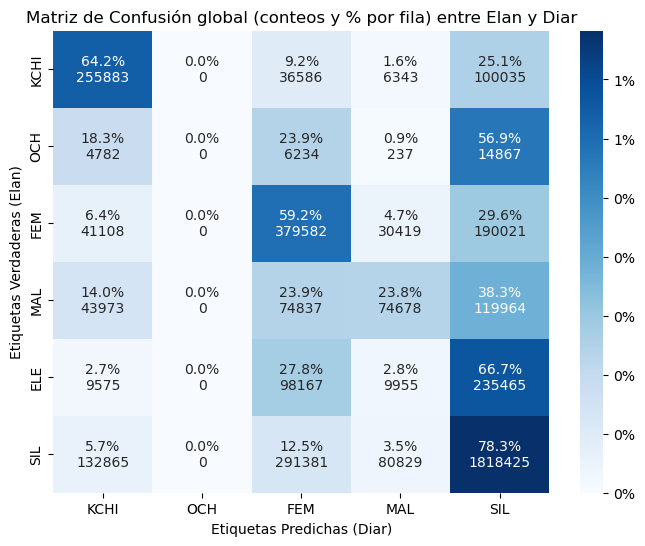

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Si ya tenés df_resultados_concat en memoria, podés usarlo directo
# Si no, lo cargás desde el CSV que generaste antes:
# df_resultados_concat = pd.read_csv("df_resultados_concat.csv")

df = df_resultados_concat.copy()

# --- 1) Crear columnas SIL y ELE a nivel global ---

# Lista de columnas Elan que queremos verificar
cols_elan = ["Elan_KCHI", "Elan_OCH", "Elan_FEM", "Elan_MAL", "Elan_ELE"]
# (cols_diar la dejo por claridad aunque no la usamos toda)
cols_diar = ["Diar_KCHI", "Diar_OCH", "Diar_FEM", "Diar_MAL", "Diar_SPEECH"]

# SIL en Elan: 1 cuando todas las etiquetas Elan_* están en 0
df["Elan_SIL"] = (df[cols_elan].eq(0).all(axis=1)).astype(int)

# SIL en Diar: 1 - SPEECH
df["Diar_SIL"] = 1 - df["Diar_SPEECH"]

# ELE en Diar: el sistema no lo predice (todo 0)
df["Diar_ELE"] = 0

# --- 2) Definir etiquetas y armar y_true / y_pred (multilabel) ---

labels = ['KCHI', 'OCH', 'FEM', 'MAL', 'ELE', 'SIL']

y_true_multi = df[['Elan_KCHI', 'Elan_OCH', 'Elan_FEM', 'Elan_MAL', 'Elan_ELE', 'Elan_SIL']].values
y_pred_multi = df[['Diar_KCHI', 'Diar_OCH', 'Diar_FEM', 'Diar_MAL', 'Diar_ELE', 'Diar_SIL']].values

# --- 3) Matriz de confusión multilabel + classification_report ---

conf_matrix = multilabel_confusion_matrix(y_true_multi, y_pred_multi)

for i, label in enumerate(labels):
    print(f"Matriz de confusión para la etiqueta {label}:")
    print(conf_matrix[i])
    print()

print("Informe de clasificación (multilabel uno-vs-rest):")
print(classification_report(y_true_multi, y_pred_multi, target_names=labels, zero_division=0))

# --- 4) Pasar de multilabel a singlelabel ---

def multilabel_to_singlelabel(y_multilabel):
    single_labels = []
    for row in y_multilabel:
        indices = np.where(row == 1)[0]
        if len(indices) == 0:
            single_labels.append(-1)  # Sin etiqueta
        else:
            # Si hay múltiples etiquetas, tomamos la primera (misma política que venías usando)
            single_labels.append(indices[0])
    return np.array(single_labels)

y_true = multilabel_to_singlelabel(y_true_multi)
y_pred = multilabel_to_singlelabel(y_pred_multi)

# --- 5) Filtrar instancias sin etiqueta en y_true ---

valid_indices = y_true != -1
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]

# --- 6) Matrices: conteos y normalizada ---

labels_idx = range(len(labels))

cm_counts = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize=None)
cm_norm   = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize='true')

cm_counts_df = pd.DataFrame(cm_counts, index=labels, columns=labels)
cm_norm_df   = pd.DataFrame(cm_norm,   index=labels, columns=labels)

# --- 7) Ocultar SOLO la columna 'ELE' en predichas (X), mantener fila 'ELE' en verdaderas (Y) ---
# (porque el sistema no predice ELE pero sí puede estar en Elan)
if 'ELE' in cm_counts_df.columns:
    cm_counts_df = cm_counts_df.drop(columns=['ELE'])
    cm_norm_df   = cm_norm_df.drop(columns=['ELE'])

# --- 8) Anotaciones tipo "xx.x%\nconteo" ---

annot = (cm_norm_df * 100).round(1).astype(str) + "%" + "\n" + cm_counts_df.astype(int).astype(str)

# --- 9) Graficar heatmap global y guardar ---

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm_df,        # intensidades = proporciones por fila
    annot=annot,       # texto = "porcentaje\nconteo"
    fmt='',
    cmap='Blues',
    cbar_kws={'format': '%.0f%%'}
)

plt.title('Matriz de Confusión global (conteos y % por fila) entre Elan y Diar')
plt.ylabel('Etiquetas Verdaderas (Elan)')
plt.xlabel('Etiquetas Predichas (Diar)')

os.makedirs('casos/df_resultados_concat', exist_ok=True)
plt.savefig('casos/df_resultados_concat/matriz_confusion_global_ELE_SIL_resultados_concat.png',
            dpi=300, bbox_inches='tight')
plt.show()



In [8]:
sns.set(style="whitegrid")

# Carpeta de salida para los resultados globales
out_dir = "casos/df_resultados_concat"
os.makedirs(out_dir, exist_ok=True)

# --- Gráfico de barras para Precisión ---
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='Precisión', data=df_metrics, palette='Blues_d')
plt.title('Precisión por Tipo')
plt.ylim(0, 1)
plt.ylabel('Precisión')

plt.savefig(f'{out_dir}/precision_resultados_concat.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Gráfico de barras para Recall ---
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='Recall', data=df_metrics, palette='Greens_d')
plt.title('Recall por Tipo')
plt.ylim(0, 1)
plt.ylabel('Recall')

plt.savefig(f'{out_dir}/recall_resultados_concat.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Gráfico de barras para F1-score ---
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='F1-score', data=df_metrics, palette='Reds_d')
plt.title('F1-score por Tipo')
plt.ylim(0, 1)
plt.ylabel('F1-score')

plt.savefig(f'{out_dir}/f1score_resultados_concat.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Gráfico combinado (Precisión / Recall / F1 en el mismo plot) ---
df_metrics_melted = pd.melt(
    df_metrics,
    id_vars=['Tipo'],
    value_vars=['Precisión', 'Recall', 'F1-score'],
    var_name='Métrica',
    value_name='Valor'
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Tipo', y='Valor', hue='Métrica', data=df_metrics_melted)
plt.title('Métricas por Tipo')
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.legend(title='Métrica')

plt.savefig(f'{out_dir}/combinado_resultados_concat.png', dpi=300, bbox_inches='tight')
plt.show()



NameError: name 'df_metrics' is not defined

<Figure size 800x600 with 0 Axes>

# Matrices por nivel SES


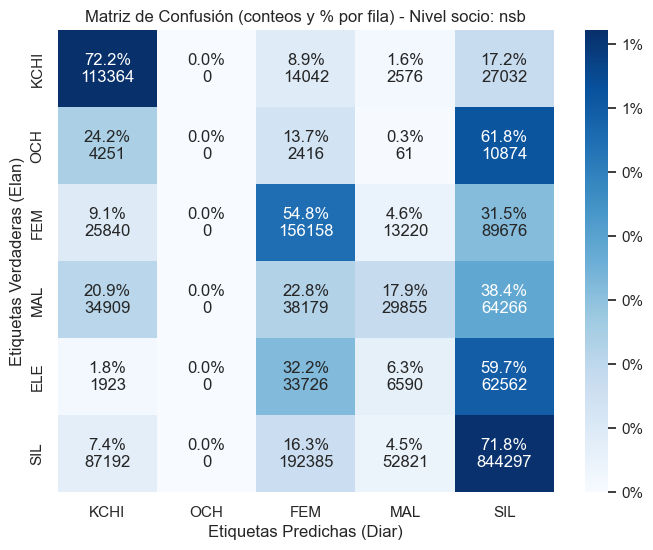

Guardada matriz para nivel socio nsb en: casos/df_resultados_concat\matriz_confusion_nsb_ELE_SIL.png


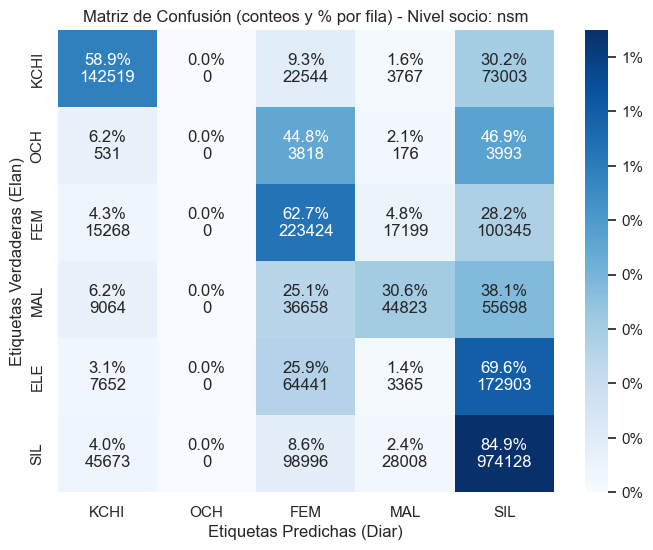

Guardada matriz para nivel socio nsm en: casos/df_resultados_concat\matriz_confusion_nsm_ELE_SIL.png


In [9]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --- Función auxiliar: multilabel -> singlelabel ---
def multilabel_to_singlelabel(y_multilabel):
    single_labels = []
    for row in y_multilabel:
        indices = np.where(row == 1)[0]
        if len(indices) == 0:
            single_labels.append(-1)  # Sin etiqueta
        else:
            single_labels.append(indices[0])  # primera etiqueta encontrada
    return np.array(single_labels)

# --- Etiquetas que vamos a usar ---
labels = ['KCHI', 'OCH', 'FEM', 'MAL', 'ELE', 'SIL']
labels_idx = range(len(labels))

# --- Carpeta base de salida ---
base_out_dir = "casos/df_resultados_concat"
os.makedirs(base_out_dir, exist_ok=True)

# --- Loop por cada nivel socioeconómico ---
for nivel, df_sub in df_resultados_concat.groupby("nivel socio"):
    if df_sub.empty:
        continue
    
    df_sub = df_sub.copy()
    
    # 1) Crear SIL y ELE a partir de las columnas de Elan/Diar
    cols_elan = ["Elan_KCHI", "Elan_OCH", "Elan_FEM", "Elan_MAL", "Elan_ELE"]
    
    # SIL en Elan: todas las columnas Elan_* en 0
    df_sub["Elan_SIL"] = (df_sub[cols_elan].eq(0).all(axis=1)).astype(int)
    
    # SIL en Diar: 1 - SPEECH
    df_sub["Diar_SIL"] = 1 - df_sub["Diar_SPEECH"]
    
    # ELE en Diar: el sistema no lo predice (todo 0)
    df_sub["Diar_ELE"] = 0
    
    # 2) y_true / y_pred multilabel
    y_true_multi = df_sub[['Elan_KCHI', 'Elan_OCH', 'Elan_FEM', 'Elan_MAL', 'Elan_ELE', 'Elan_SIL']].values
    y_pred_multi = df_sub[['Diar_KCHI', 'Diar_OCH', 'Diar_FEM', 'Diar_MAL', 'Diar_ELE', 'Diar_SIL']].values
    
    # 3) Pasar a singlelabel
    y_true = multilabel_to_singlelabel(y_true_multi)
    y_pred = multilabel_to_singlelabel(y_pred_multi)
    
    # Filtrar sin etiqueta
    valid_indices = y_true != -1
    y_true = y_true[valid_indices]
    y_pred = y_pred[valid_indices]
    
    if len(y_true) == 0:
        print(f"No hay instancias etiquetadas para nivel socio {nivel}, se salta.")
        continue
    
    # 4) Matrices de confusión (conteos y normalizada por fila)
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize=None)
    cm_norm   = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize='true')
    
    cm_counts_df = pd.DataFrame(cm_counts, index=labels, columns=labels)
    cm_norm_df   = pd.DataFrame(cm_norm,   index=labels, columns=labels)
    
    # Ocultar SOLO la columna ELE en predichas
    if 'ELE' in cm_counts_df.columns:
        cm_counts_df = cm_counts_df.drop(columns=['ELE'])
        cm_norm_df   = cm_norm_df.drop(columns=['ELE'])
    
    # 5) Anotaciones "xx.x%\nconteo"
    annot = (cm_norm_df * 100).round(1).astype(str) + "%" + "\n" + cm_counts_df.astype(int).astype(str)
    
    # 6) Graficar
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_norm_df,
        annot=annot,
        fmt='',
        cmap='Blues',
        cbar_kws={'format': '%.0f%%'}
    )
    
    plt.title(f'Matriz de Confusión (conteos y % por fila) - Nivel socio: {nivel}')
    plt.ylabel('Etiquetas Verdaderas (Elan)')
    plt.xlabel('Etiquetas Predichas (Diar)')
    
    # 7) Guardar por nivel socioeconómico
    nivel_str = str(nivel)
    out_path = os.path.join(base_out_dir, f"matriz_confusion_{nivel_str}_ELE_SIL.png")
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Guardada matriz para nivel socio {nivel} en: {out_path}")
